In [1]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import rospy
import rosbag

from visualization_msgs.msg import Marker, MarkerArray
from geometry_msgs.msg import Twist, PoseStamped, Pose
from std_msgs.msg import Bool
import tf
from geometry_msgs.msg import Quaternion

import sys
# sys.path.insert(0, "../expert_demo_ros/src/")


from utils.environment import *

In [130]:
# bag = rosbag.Bag("../expert_demo_ros/bags/2020-07-21-15-47-14.bag")
bag = rosbag.Bag("../expert_demo_ros/bags/2020-07-22-11-23-48.bag")

A_MAX = rospy.get_param("A_MAX", 0.1)
V_MAX = rospy.get_param("V_MAX", 5.0)
DELTA_MAX = rospy.get_param("DELTA_MAX", 18*np.pi/180)


In [131]:
states = []
for topic, msg, t in bag.read_messages(topics=['/robot/state']):
    x, y = msg.pose.position.x, msg.pose.position.y
    quat = msg.pose.orientation
    th = tf.transformations.euler_from_quaternion([quat.x, quat.y, quat.z, quat.w])[2]
    V = msg.twist.linear.x
    beta = msg.twist.linear.y
    time = msg.header.stamp.secs + msg.header.stamp.nsecs*1e-9
    states.append([time, x, y, th, V, beta])
states = np.array(states)


In [132]:
controls = []
for topic, msg, t in bag.read_messages(topics=['/robot/control']):
    b, a, d = msg.data.data
    brake = -(1 - b) * 0.5 * A_MAX
    accel = (1 - a) * 0.5 * A_MAX
    delta = d * DELTA_MAX
    time = msg.header.stamp.secs + msg.header.stamp.nsecs*1e-9
    controls.append([time, brake+accel, delta])
controls = np.array(controls)

## interpolating

In [133]:
dt = 0.5
start_time = controls[np.where(controls[:,1] != 0)[0][0], 0]
controls[:,0] -= start_time
states[:,0] -= start_time
times = np.arange(0, controls[-1,0], dt)
controls_even = np.stack([np.interp(times, controls[:,0], controls[:,i]) for i in [1,2]]).T
states_even = np.stack([np.interp(times, states[:,0], states[:,i]) for i in [1,2,3,4]]).T


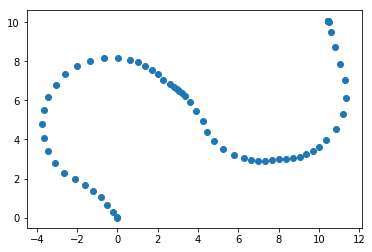

In [134]:
plt.scatter(states_even[:,0], states_even[:,1])

Text(0,0.5,u'Steering [degrees]')

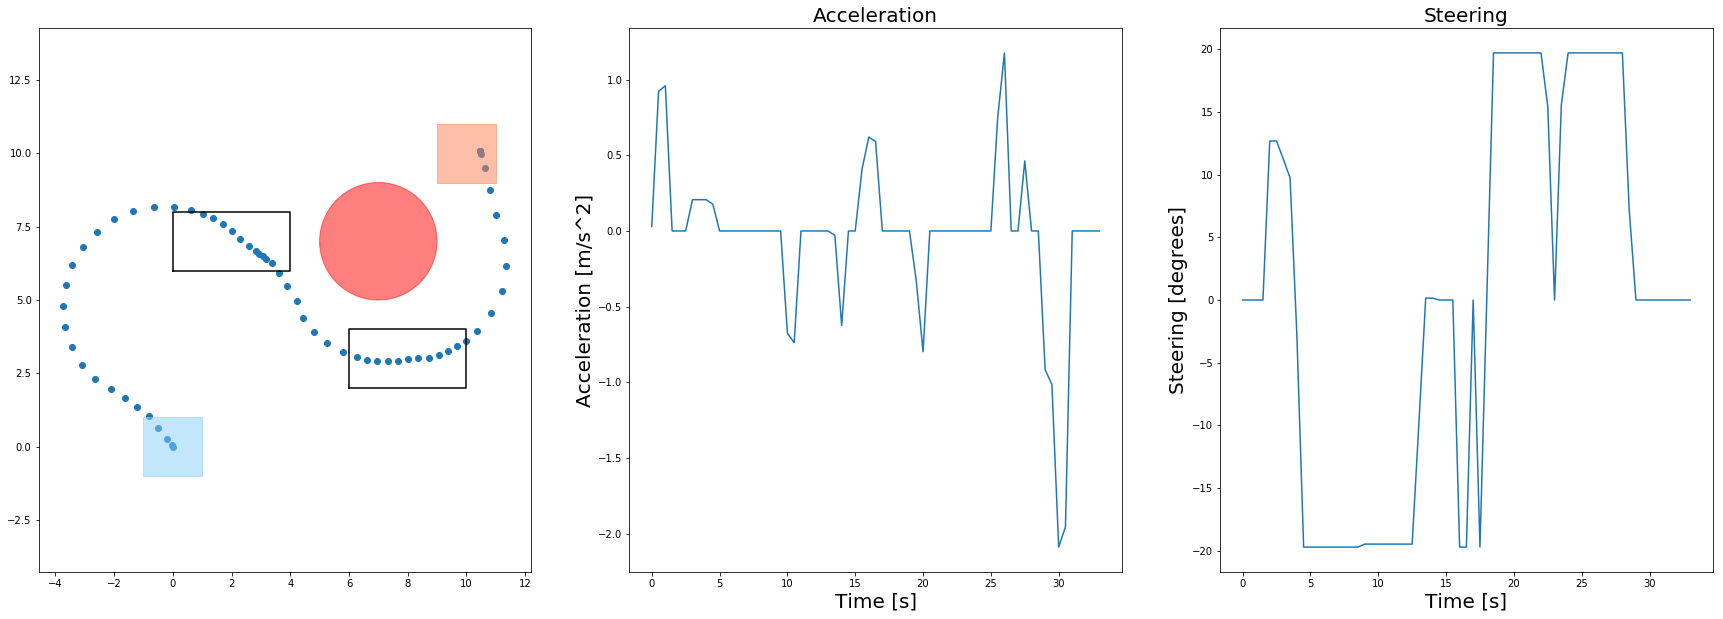

In [135]:

N = 100
params = {  "covers": [Box([0., 6.],[4, 8.]), Box([6., 2.],[10.0, 4.0])],
            "obstacles": [Circle([7., 7.], 2.0)],
            "initial": Box([-1., -1.],[1., 1.]),
            "final": Box([9.0, 9.0],[11.0, 11.0])
       }
draw_params = {"initial": {"color": "lightskyblue", "fill": True, "alpha": 0.5}, "final": {"color": "coral", "fill": True, "alpha": 0.5}, "covers": {"color": "black", "fill": False}, "obs": {"color": "red", "fill": True, "alpha": 0.5} }
cov_env = CoverageEnv(params)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
cov_env.draw2D(kwargs=draw_params)
plt.axis("equal")

alpha = states_even[:,3]/V_MAX
color_list = np.ones([alpha.shape[0], 3])
color_list[:,0] = alpha
# color_list[:,1] =  1 - alpha
plt.scatter(states_even[:,0], states_even[:,1])

plt.subplot(1,3,2)
plt.plot(times, controls_even[:,0])
plt.title("Acceleration", fontsize=20)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Acceleration [m/s^2]", fontsize=20)

plt.subplot(1,3,3)
plt.plot(times, controls_even[:,1]*180/np.pi)
plt.title("Steering", fontsize=20)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Steering [degrees]", fontsize=20)

In [149]:
import scipy.io as sio


In [152]:
times.shape, states_even.shape

((67,), (67, 4))

In [153]:
sio.savemat('../hji/data/expert_traj.mat', {'expert_traj': states_even, 'time': times})

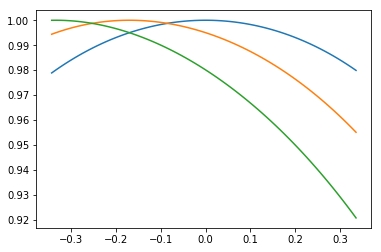

In [146]:
lr = 0.7
lf = 0.5
delta = np.arange(-DELTA_MAX, DELTA_MAX, 0.01)


alpha = [0, -0.1, -0.2]
for a in alpha:
    y = np.cos(np.arctan(lr / (lr + lf) * np.tan(delta)) - a)
    plt.plot(delta, y)


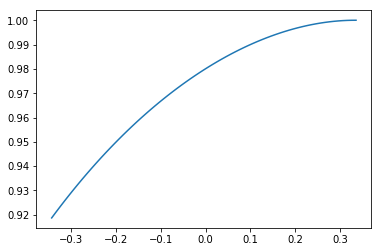

In [141]:
plt.plot(delta, y)